In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from outliers import smirnov_grubbs as grubbs
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import statsmodels.api as sm
import pingouin as pg
from scipy.stats import kstest

%load_ext rpy2.ipython

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


In [2]:
%%R

library(readr)
library(tidyr)
library(tibble)
library(car)
library(outliers)
library(corrplot)
library(mice)
library(nortest)
library(ggplot2)
library(dplyr)
library(gridExtra)

R callback write-console: <class 'UnicodeDecodeError'> 'utf-8' codec can't decode byte 0xc7 in position 0: invalid continuation byte <traceback object at 0x000002126BD2B400>
R callback write-console: <class 'UnicodeDecodeError'> 'utf-8' codec can't decode byte 0xcf in position 1: invalid continuation byte <traceback object at 0x000002126BD2B440>
R callback write-console: <class 'UnicodeDecodeError'> 'utf-8' codec can't decode byte 0xd1 in position 0: invalid continuation byte <traceback object at 0x000002126BD2B900>
R callback write-console: <class 'UnicodeDecodeError'> 'utf-8' codec can't decode byte 0xd1 in position 0: invalid continuation byte <traceback object at 0x000002126BD2B4C0>
R callback write-console: <class 'UnicodeDecodeError'> 'utf-8' codec can't decode byte 0xcf in position 1: invalid continuation byte <traceback object at 0x000002126BD2B9C0>
R callback write-console: <class 'UnicodeDecodeError'> 'utf-8' codec can't decode byte 0xd1 in position 0: invalid continuation by

corrplot 0.95 loaded


## 1. Выбрать уникальные для каждого студента в группе датасеты для выполнения заданий практикума. Подготовить их описание, краткие характеристики (максимумы-минимумы, средние значения, пропуски и т.п.).

In [3]:
%%R

ds <- read.csv('StudentsPerformance.csv', header=TRUE)

In [4]:
ds = pd.read_csv('StudentsPerformance.csv')
ds

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


### Расшифровка каждой колонки:

gender	– Пол учащегося — male (мальчик) или female (девочка).

race/ethnicity –	Этническая группа студента, закодирована как group A, group B, … group E.

parental level of education –	Максимальный уровень образования родителей (high school, bachelor’s degree, master’s degree).

lunch	Тип школьного питания – standard — обычный обед, free/reduced — льготный обед

test preparation course –	Проходил ли ученик подготовительный курс перед экзаменом (none или completed).

math score –	Балл по математике (от 0 до 100).

reading score –	Балл по чтению (от 0 до 100).

writing score –	Балл по письму (от 0 до 100).

In [5]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


Пропусков в нашем датасете нет

In [6]:
ds.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


## 2. Реализовать аппроксимацию распределений данных с помощью ядерных оценок

In [7]:
colomns_for_print = ['math score', 'reading score', 'writing score']

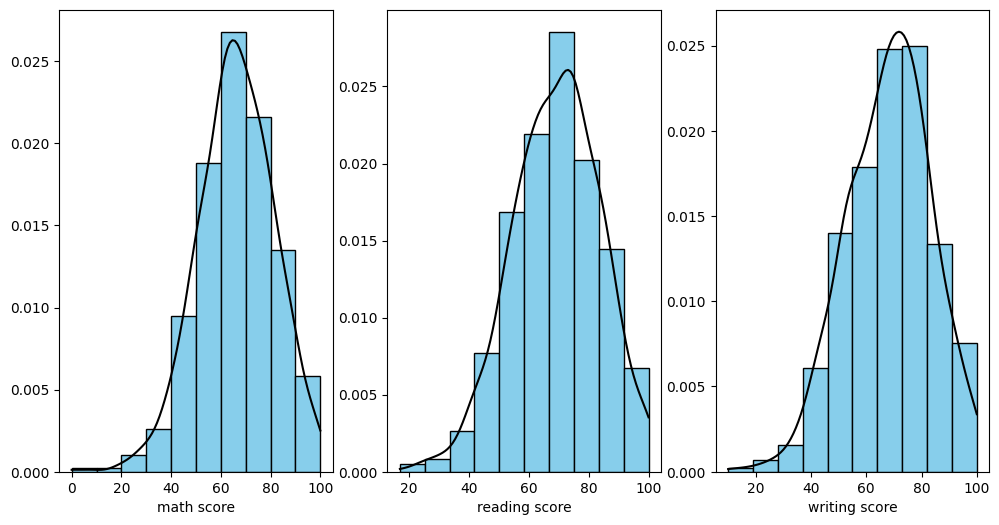

In [8]:
count = 0
plt.figure(figsize=(12, 6))
for i in colomns_for_print:
    count += 1
    plt.subplot(1, 3, count)
    data = ds[i]
    x = np.linspace(data.min(), data.max(), 100)
    plt.hist(data, density=True, color='skyblue', edgecolor='black')
    plt.xlabel(f'{i}')
    plt.plot(x, stats.gaussian_kde(data)(x), color='black')

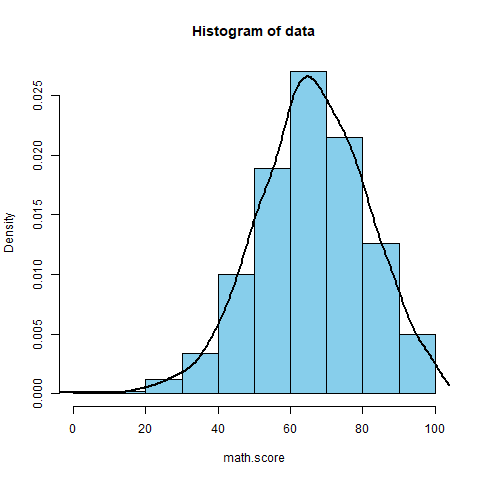

In [9]:
%%R

colomns_for_print <- c('math.score')
for(i in 1:length(colomns_for_print)) {
    col_name <- colomns_for_print[i]
    data <- ds[[col_name]]
    hist(data, prob=TRUE, col='skyblue', border='black', xlab = col_name)
    lines(density(data), col = 'black', lwd = 2)
}

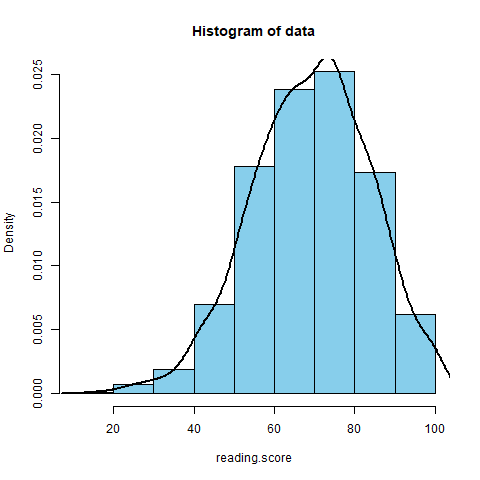

In [10]:
%%R

colomns_for_print <- c('reading.score')
for(i in 1:length(colomns_for_print)) {
    col_name <- colomns_for_print[i]
    data <- ds[[col_name]]
    hist(data, prob=TRUE, col='skyblue', border='black', xlab = col_name)
    lines(density(data), col = 'black', lwd = 2)
}

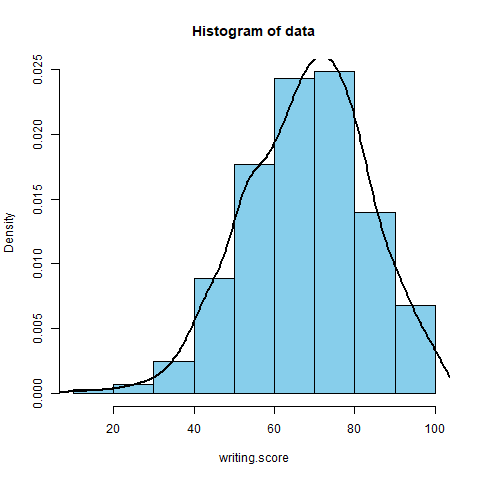

In [11]:
%%R

colomns_for_print <- c('writing.score')
for(i in 1:length(colomns_for_print)) {
    col_name <- colomns_for_print[i]
    data <- ds[[col_name]]
    hist(data, prob=TRUE, col='skyblue', border='black', xlab = col_name)
    lines(density(data), col = 'black', lwd = 2)
}

## 3. Реализовать анализ данных с помощью cdplot, dotchart, boxplot и stripchart.

### 3.1 cdplot

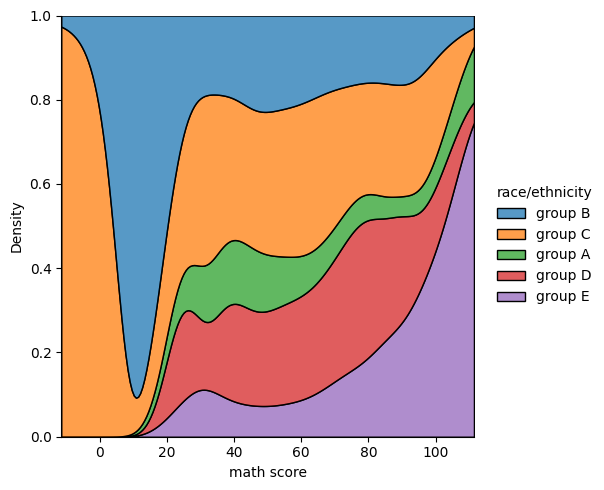

In [12]:
sns.displot(ds, x='math score', hue='race/ethnicity', kind='kde', multiple='fill')

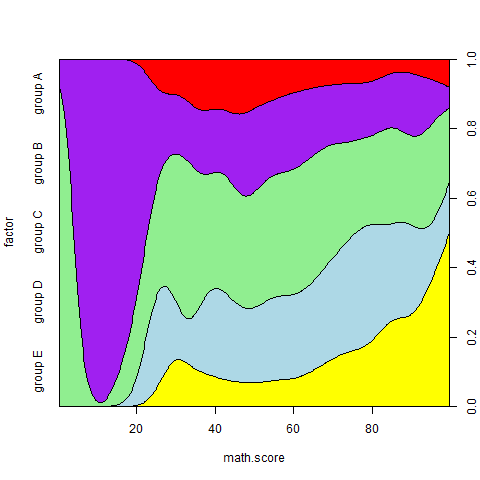

In [13]:
%%R

ds$factor <- as.factor(ds$race.ethnicity)
cdplot(factor ~ math.score, data = ds, col = c("yellow", "lightblue", "lightgreen", "purple", "red"))

### 3.2 dotchart

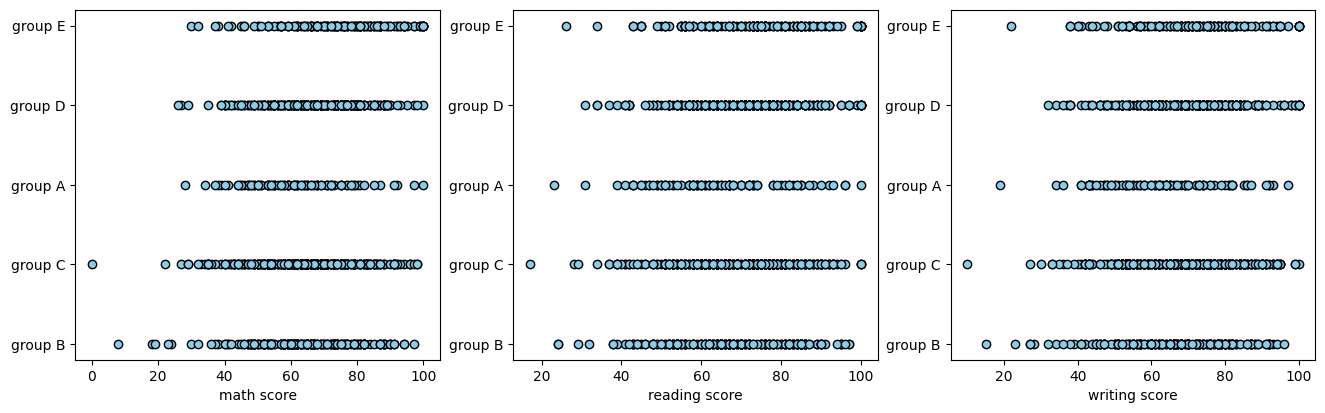

In [14]:
count = 0
plt.figure(figsize=(16, 10))
for i in colomns_for_print:
    count += 1
    plt.subplot(2, 3, count)
    plt.scatter(ds[i], ds['race/ethnicity'], color='skyblue', edgecolor='black')
    plt.xlabel(f'{i}')

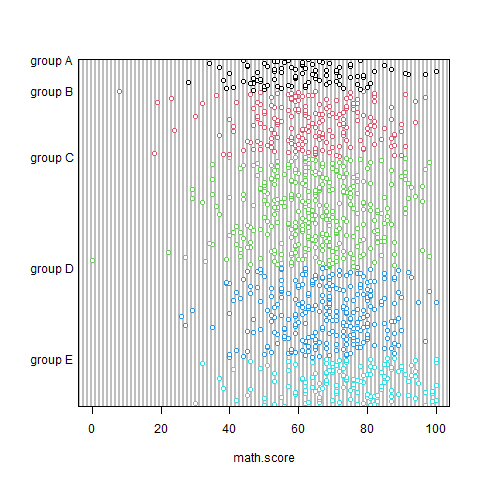

In [15]:
%%R
colomns_for_print <- c('math.score')
for(i in 1:length(colomns_for_print)) {
    col_name <- colomns_for_print[i]
    factor <- as.factor(ds$race.ethnicity)
    dotchart(ds[[col_name]], groups = factor, color = as.numeric(factor), xlab = col_name)
}

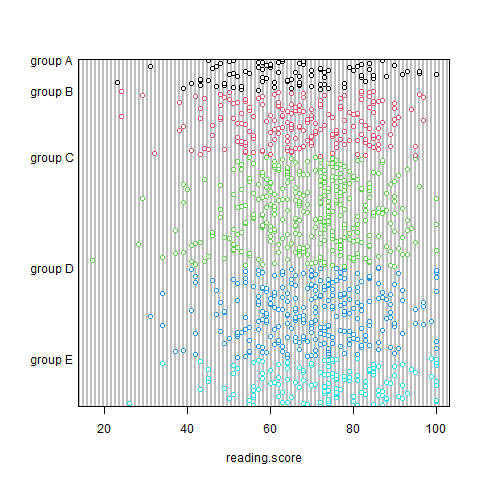

In [16]:
%%R
colomns_for_print <- c('reading.score')
for(i in 1:length(colomns_for_print)) {
    col_name <- colomns_for_print[i]
    factor <- as.factor(ds$race.ethnicity)
    dotchart(ds[[col_name]], groups = factor, color = as.numeric(factor), xlab = col_name)
}

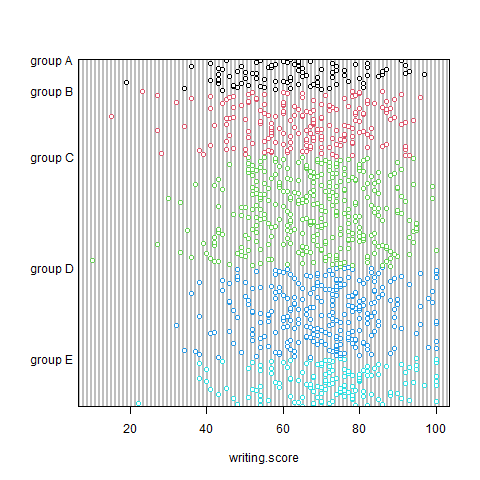

In [17]:
%%R
colomns_for_print <- c('writing.score')
for(i in 1:length(colomns_for_print)) {
    col_name <- colomns_for_print[i]
    factor <- as.factor(ds$race.ethnicity)
    dotchart(ds[[col_name]], groups = factor, color = as.numeric(factor), xlab = col_name)
}

### 3.3 boxplot

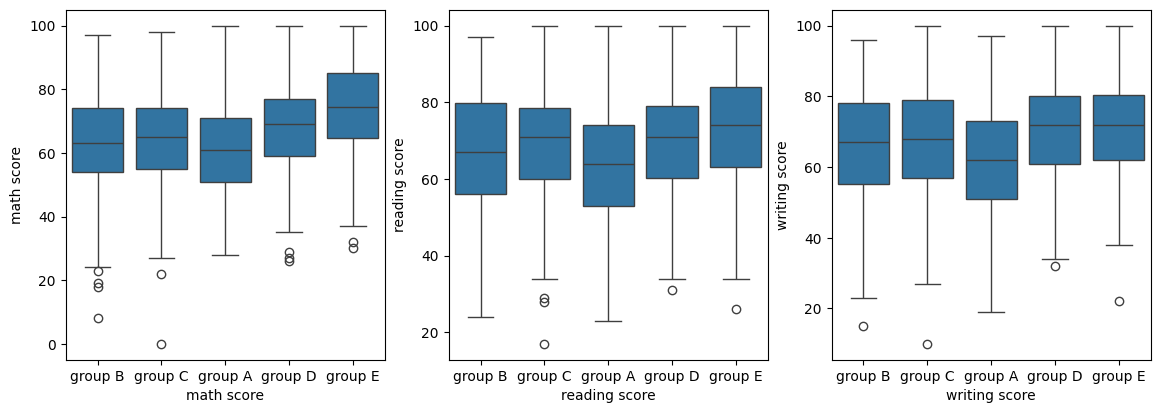

In [18]:
count = 0
plt.figure(figsize=(14, 10))
for i in colomns_for_print:
    count += 1
    plt.subplot(2, 3, count)
    sns.boxplot(ds, x='race/ethnicity', y=i)
    plt.xlabel(f'{i}')

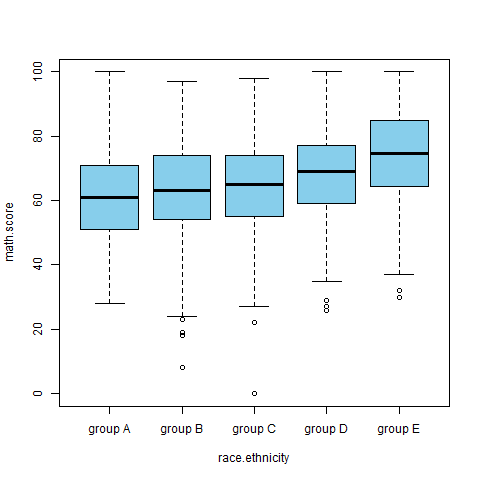

In [19]:
%%R
colomns_for_print <- c('math.score')
for(i in 1:length(colomns_for_print)) {
    col_name <- colomns_for_print[i]
    boxplot(ds[[col_name]] ~ ds$race.ethnicity, col = 'skyblue', xlab = 'race.ethnicity', ylab = col_name)
}


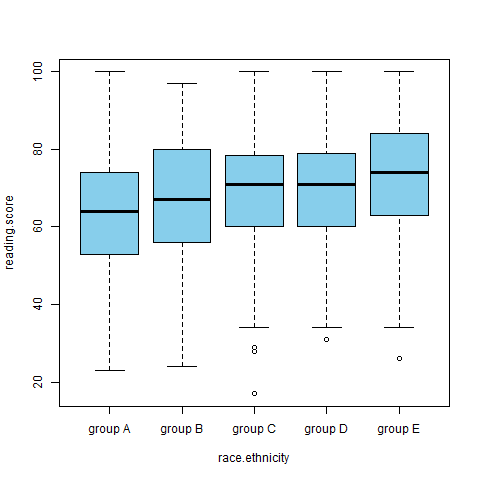

In [20]:
%%R
colomns_for_print <- c('reading.score')
for(i in 1:length(colomns_for_print)) {
    col_name <- colomns_for_print[i]
    boxplot(ds[[col_name]] ~ ds$race.ethnicity, col = 'skyblue', xlab = 'race.ethnicity', ylab = col_name)
}


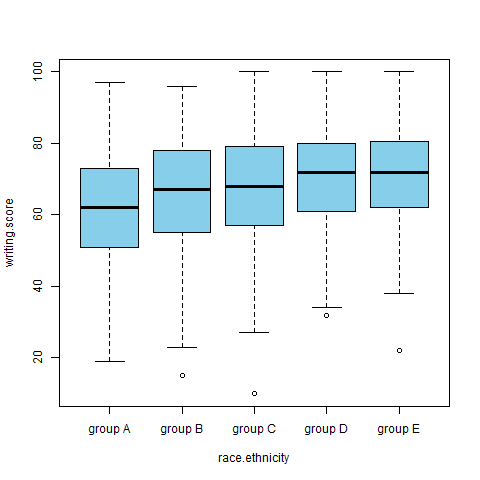

In [21]:
%%R
colomns_for_print <- c('writing.score')
for(i in 1:length(colomns_for_print)) {
    col_name <- colomns_for_print[i]
    boxplot(ds[[col_name]] ~ ds$race.ethnicity, col = 'skyblue', xlab = 'race.ethnicity', ylab = col_name)
}


### 3.4 stripchart

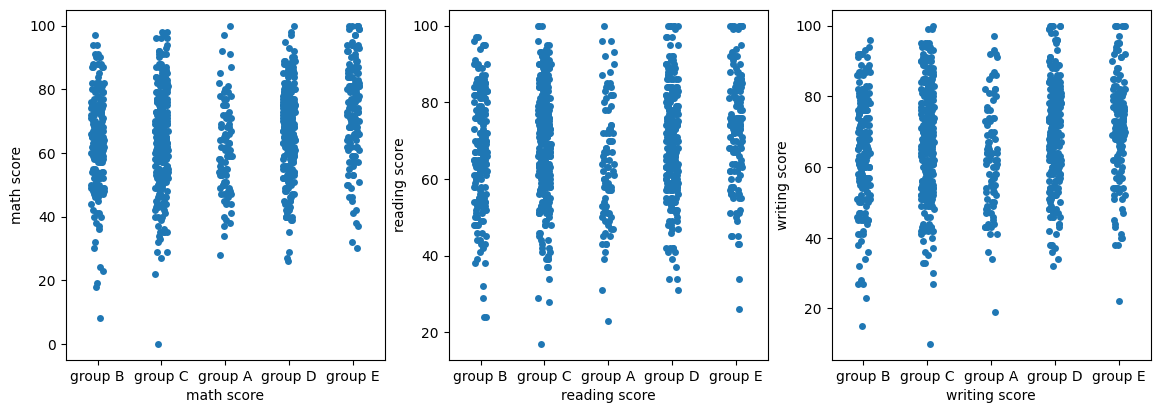

In [22]:
count = 0
plt.figure(figsize=(14, 10))
for i in colomns_for_print:
    count += 1
    plt.subplot(2, 3, count)
    sns.stripplot(ds, x='race/ethnicity', y=i)
    plt.xlabel(f'{i}')

### 3.4 stripchart

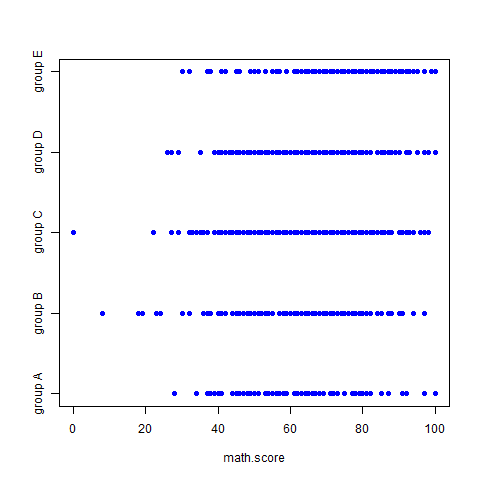

In [23]:
%%R

colomns_for_print <- c('math.score')
for(i in 1:length(colomns_for_print)){
    col_name <- colomns_for_print[i]
    stripchart(ds[[col_name]] ~ ds$race.ethnicity, xlab = col_name, col = "blue", pch = 16)
}

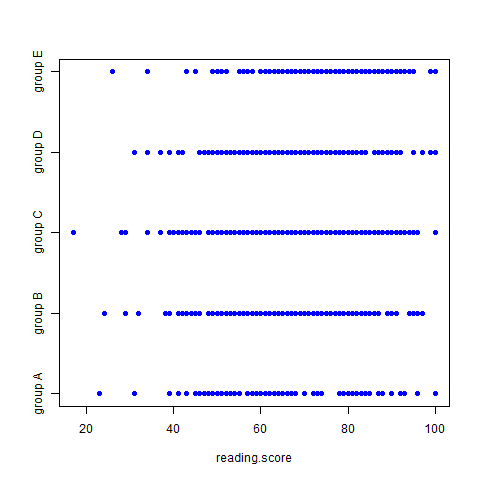

In [24]:
%%R

colomns_for_print <- c('reading.score')
for(i in 1:length(colomns_for_print)){
    col_name <- colomns_for_print[i]
    stripchart(ds[[col_name]] ~ ds$race.ethnicity, xlab = col_name, col = "blue", pch = 16)
}

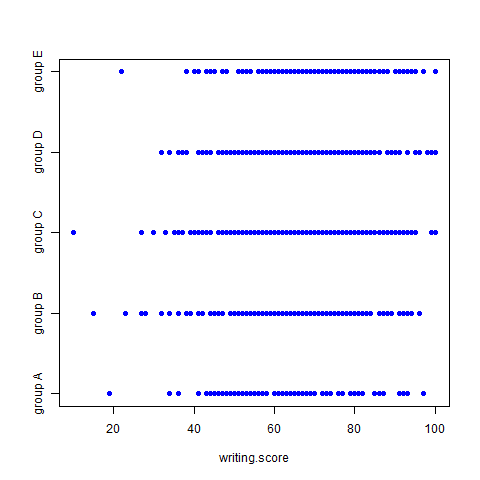

In [25]:
%%R

colomns_for_print <- c('writing.score')
for(i in 1:length(colomns_for_print)){
    col_name <- colomns_for_print[i]
    stripchart(ds[[col_name]] ~ ds$race.ethnicity, xlab = col_name, col = "blue", pch = 16)
}

## 4. Проверить, являются ли наблюдения выбросами с точки зрения формальных статистических критериев Граббса и Q-теста Диксона. Визуализировать результаты.

### 4.1 Критерий Граббса

In [26]:
for i in colomns_for_print:
    ind = grubbs.max_test_indices(ds[i], alpha=0.5)
    print("Индексы выбросов в столбце", i, ind)
    print("Значения: ", end='')
    for j in ind:
        print(ds[i][j], end=' ')
    print()

Индексы выбросов в столбце math score []
Значения: 
Индексы выбросов в столбце reading score []
Значения: 
Индексы выбросов в столбце writing score []
Значения: 


In [27]:
%%R

colomns_for_print <- c('math.score', 'reading.score', 'writing.score')
for(i in 1:length(colomns_for_print)) {
    col_name <- colomns_for_print[i]
    data <- ds[[col_name]]
    print(col_name)
    print(grubbs.test(data))
}

[1] "math.score"

	Grubbs test for one outlier

data:  data
G = 4.35855, U = 0.98097, p-value = 0.005977
alternative hypothesis: lowest value 0 is an outlier

[1] "reading.score"

	Grubbs test for one outlier

data:  data
G = 3.57317, U = 0.98721, p-value = 0.1693
alternative hypothesis: lowest value 17 is an outlier

[1] "writing.score"

	Grubbs test for one outlier

data:  data
G = 3.82043, U = 0.98538, p-value = 0.06315
alternative hypothesis: lowest value 10 is an outlier



### 4.2 Q-тест Диксона

Q-тест Диксона реализован только в R.
Тест работает не более чем на 30 элементах

In [28]:
%%R

data <- ds$math.score[210:239]
dixon.test(data)


	Dixon test for outliers

data:  data
Q = 0.15094, p-value = 0.7847
alternative hypothesis: lowest value 34 is an outlier



## 5. Воспользоваться инструментами для заполнения пропусков в данных. Пропуски внести вручную и сравнить результаты заполнения с истинными значениями.

In [29]:
sp = ds.copy()
sp['math score'][0:50] = None
sp

C:\Users\aleks\AppData\Local\Temp\ipykernel_13524\3636856483.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sp['math score'][0:50] = None
C:\Users\aleks\AppData\Local\Temp\ipykernel_13524\3636856483.py:2: SettingWithCopyWarning: 
A valu

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,NaN,72,74
1,female,group C,some college,standard,completed,NaN,90,88
2,female,group B,master's degree,standard,none,NaN,95,93
3,male,group A,associate's degree,free/reduced,none,NaN,57,44
4,male,group C,some college,standard,none,NaN,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88.0,99,95
996,male,group C,high school,free/reduced,none,62.0,55,55
997,female,group C,high school,free/reduced,completed,59.0,71,65
998,female,group D,some college,standard,completed,68.0,78,77


Text(0.5, 1.0, 'Исходное')

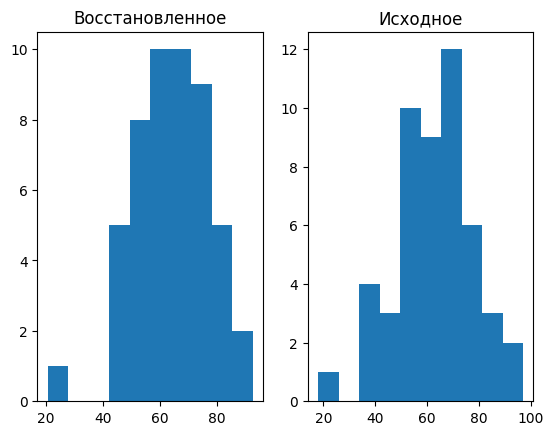

In [30]:
cat_col = sp.select_dtypes(include=['object']).columns
for i in cat_col:
    sp[i] = pd.factorize(sp[i])[0]
imp = IterativeImputer()
imp.fit(sp)
sp_imp = imp.transform(sp)
sp = sp = pd.DataFrame(sp_imp, columns=sp.columns)

plt.subplot(1, 2, 1)
plt.hist(sp['math score'][0:50])
plt.title('Восстановленное')

plt.subplot(1, 2, 2)
plt.hist(ds['math score'][0:50])
plt.title('Исходное')

In addition: Warning message:
Number of logged events: 1 


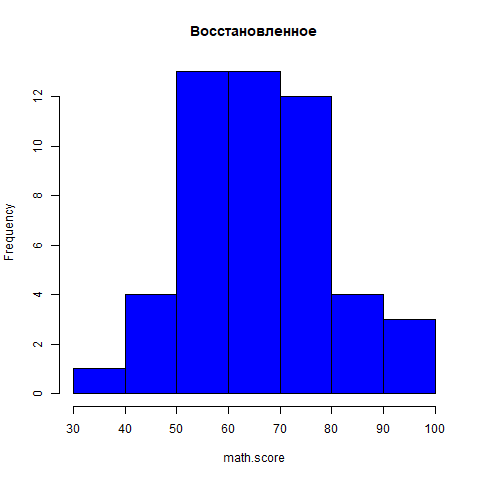

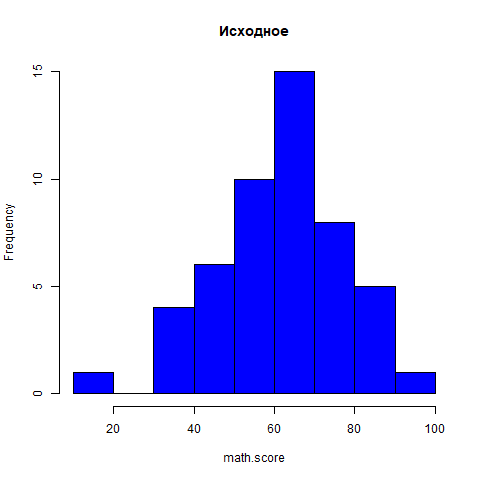

In [31]:
%%R

sp <- ds
sp$math.score[1:50] <- NA
cat_col <- names(sp)[sapply(sp, is.character)]
for(i in cat_col) {
    sp[[i]] <- as.numeric(factor(sp[[i]]))
}

imp <- mice(sp, method="pmm", m=1, printFlag=FALSE)
sp_imp <- complete(imp)
sp <- as.data.frame(sp_imp)

hist(sp$math.score[1:50], main="Восстановленное", xlab="math.score", col="blue")
hist(ds$math.score[1:50], main="Исходное", xlab="math.score", col="Blue")

## 6. Сгенерировать данные из нормального распределения с различными параметрами и провести анализ с помощью графиков эмпирических функций распределений, квантилей, метода огибающих, а также стандартных процедур проверки гипотез о нормальности (критерии Колмогорова-Смирнова, ШапироУилка, Андерсона-Дарлинга, Крамера фон Мизеса, Колмогорова-Смирнова в модификации Лиллиефорса и Шапиро-Франсия). Рассмотреть выборки малого (не более 50-100 элементов) и умеренного (1000-5000 наблюдений) объемов

### 6.1 Генерация данных и графики эмчирических функций распределения

In [32]:
data_1 = np.random.normal(0, 1, 2000)
data_2 = np.random.normal(5, 8, 75)

data_arr = [data_1, data_2]

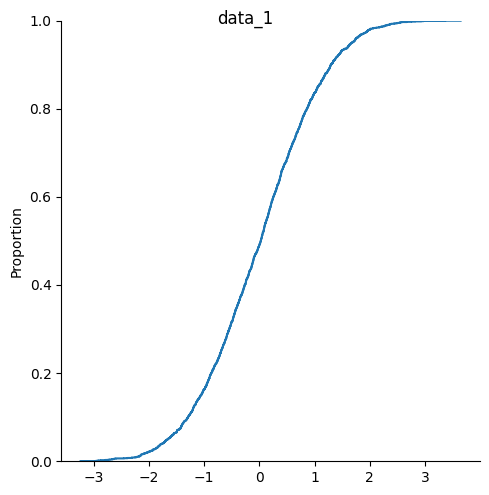

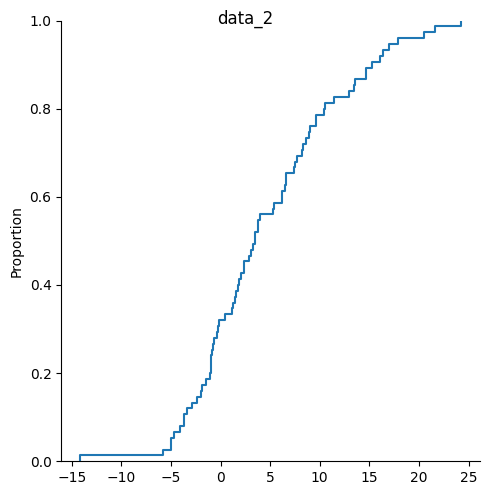

In [33]:
for i in range(1, 3):
    sns.displot(data_arr[i - 1], kind="ecdf")
    plt.suptitle("data_" + str(i))

In [34]:
%%R

data_1 <- rnorm(2000, 0, 1)
data_2 <- rnorm(75, 5, 8)

data_arr <- list(data_1, data_2)

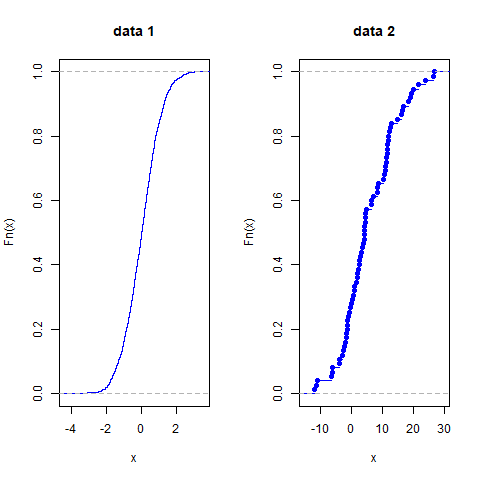

In [35]:
%%R

par(mfrow = c(1, 2))
for(i in 1:2){
    plot(ecdf(data_arr[[i]]), col="blue", main=paste("data", i))
}

### 6.2 Квантили

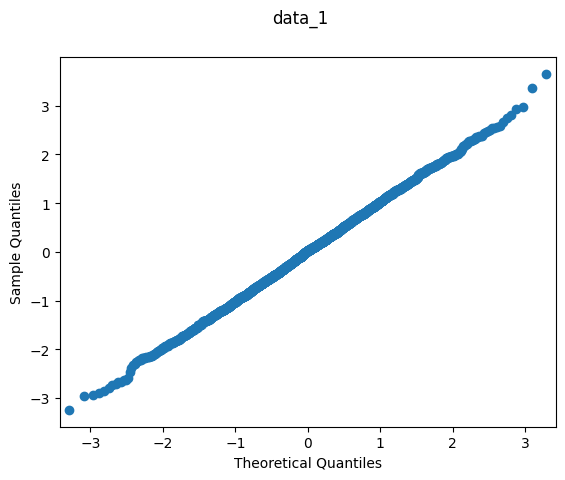

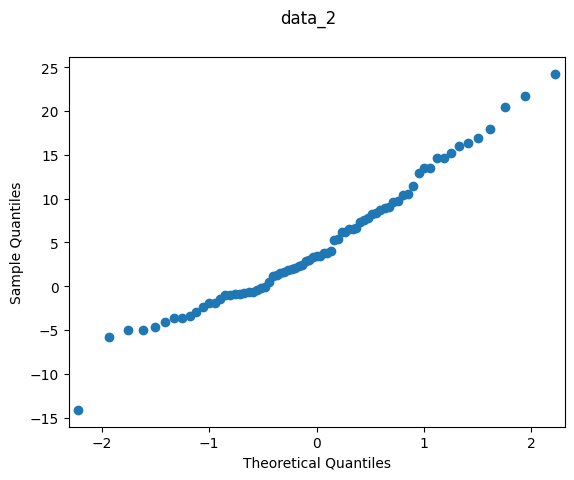

In [36]:
for i in range(1, 3):
    sm.qqplot(data_arr[i - 1])
    plt.suptitle("data_" + str(i))

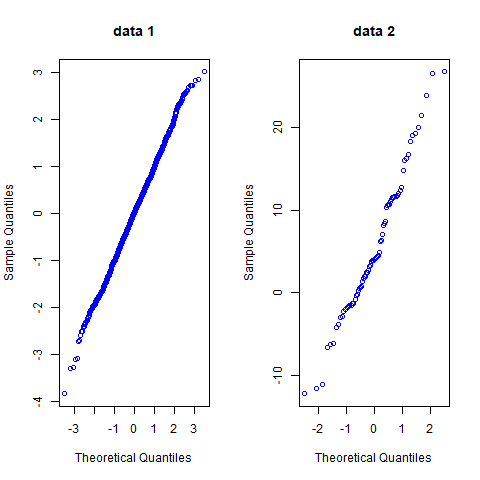

In [37]:
%%R

par(mfrow = c(1, 2))
for(i in 1:2){
    qqnorm(data_arr[[i]], col="blue", main=paste("data", i))
}

### 6.3 Метод огибающих

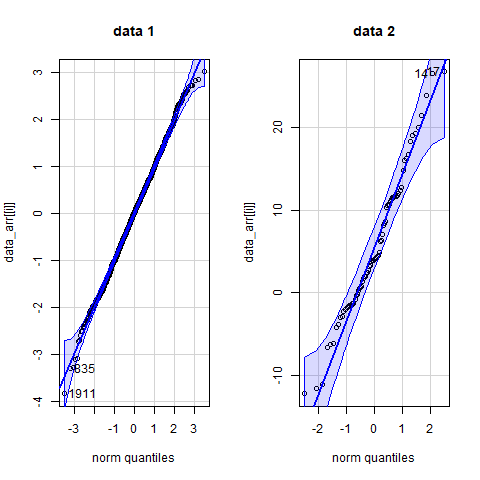

In [38]:
%%R

par(mfrow = c(1, 2))
for(i in 1:2) {
    qqPlot(data_arr[[i]], main=paste("data", i), envelope=0.95)
}

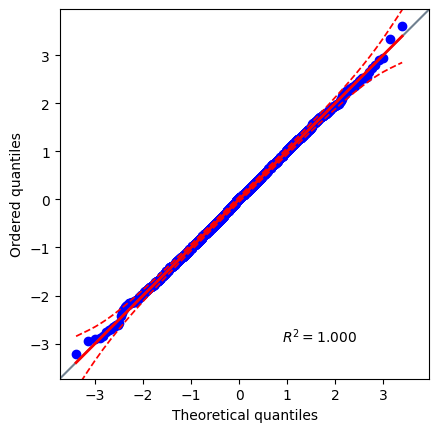

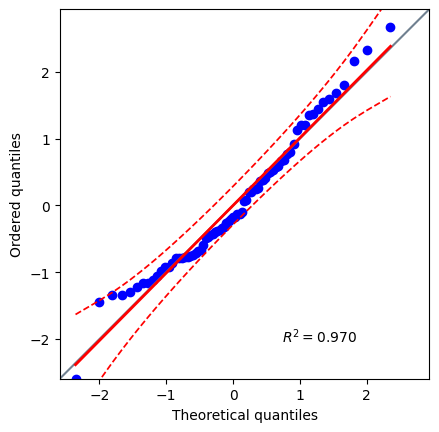

In [39]:
for i in range(2):
    pg.qqplot(data_arr[i], dist='norm', confidence=0.95)
    plt.show()

### 6.4 Критерий Колмогорова-Смирнова

In [40]:
for i in range(2):
    print("data_" + str(i + 1), kstest(data_arr[i], 'norm'))

data_1 KstestResult(statistic=np.float64(0.011634950390136234), pvalue=np.float64(0.9464950689225374), statistic_location=np.float64(0.020392710000110482), statistic_sign=np.int8(-1))
data_2 KstestResult(statistic=np.float64(0.5775881411287349), pvalue=np.float64(2.9728150495829265e-24), statistic_location=np.float64(1.8023498226314372), statistic_sign=np.int8(-1))


In [41]:
%%R

for(i in 1:2) {
    print(ks.test(data_arr[[i]], 'pnorm'))
}


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  data_arr[[i]]
D = 0.011128, p-value = 0.9654
alternative hypothesis: two-sided


	Exact one-sample Kolmogorov-Smirnov test

data:  data_arr[[i]]
D = 0.61529, p-value < 2.2e-16
alternative hypothesis: two-sided



### 6.5 Критерий Шапиро-Уилка

In [42]:
for i in range(2):
    print("data_" + str(i + 1), stats.shapiro(data_arr[i]))

data_1 ShapiroResult(statistic=np.float64(0.9994982900092728), pvalue=np.float64(0.906683318450395))
data_2 ShapiroResult(statistic=np.float64(0.971887008164131), pvalue=np.float64(0.09345679061221061))


In [43]:
%%R

for(i in 1:2) {
    print(shapiro.test(data_arr[[i]]))
}


	Shapiro-Wilk normality test

data:  data_arr[[i]]
W = 0.99906, p-value = 0.3934


	Shapiro-Wilk normality test

data:  data_arr[[i]]
W = 0.97623, p-value = 0.1702



### 6.6 Критерий Андерсона-Дарлинга

In [44]:
for i in range(2):
    print("data_" + str(i + 1), stats.anderson(data_arr[i]))

data_1 AndersonResult(statistic=np.float64(0.20683409639536876), critical_values=array([0.575, 0.655, 0.785, 0.916, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(0.0037877216614734042), scale=np.float64(1.0091633217612714))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
data_2 AndersonResult(statistic=np.float64(0.7830197368504059), critical_values=array([0.549, 0.625, 0.75 , 0.875, 1.041]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(4.746085273624733), scale=np.float64(7.332205157791108))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


In [45]:
%%R

for(i in 1:2) {
    print(ad.test(data_arr[[i]]))
}


	Anderson-Darling normality test

data:  data_arr[[i]]
A = 0.2571, p-value = 0.7208


	Anderson-Darling normality test

data:  data_arr[[i]]
A = 0.65117, p-value = 0.08591



### 6.7 Критерий Крамера фон Мизеса

In [46]:
for i in range(2):
    print("data_" + str(i + 1), stats.cramervonmises(data_arr[i], 'norm'))

data_1 CramerVonMisesResult(statistic=0.05419739002613496, pvalue=0.8504718477482827)
data_2 CramerVonMisesResult(statistic=7.165660382997263, pvalue=2.9854851923971637e-10)


In [47]:
%%R

for(i in 1:2) {
    print(cvm.test(data_arr[[i]]))
}


	Cramer-von Mises normality test

data:  data_arr[[i]]
W = 0.031102, p-value = 0.832


	Cramer-von Mises normality test

data:  data_arr[[i]]
W = 0.11992, p-value = 0.05868



### 6.8 Критерий Колмогорова-Смирнова в модификации Лиллиефорса и Шапиро-Франсия

In [48]:
from statsmodels.stats.diagnostic import lilliefors

for i in range(2):
    print("data_" + str(i + 1), lilliefors(data_arr[i], 'norm'))

data_1 (np.float64(0.010544620700333796), np.float64(0.8635942353715996))
data_2 (np.float64(0.09896383290019994), np.float64(0.09366969130875352))


In [49]:
%%R

for(i in 1:2) {
    print(lillie.test(data_arr[[i]]))
}


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  data_arr[[i]]
D = 0.010026, p-value = 0.8963


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  

data_arr[[i]]
D = 0.11365, p-value = 0.01779



## 7. Продемонстрировать пример анализа данных с помощью графиков квантилей, метода огибающих, а также стандартных процедур проверки гипотез о нормальности. Рассмотреть выборки малого и умеренного объемов

In [50]:
%%R

data_1 <- ds[['math.score']]
data_2 <- ds[['math.score']][50:100]

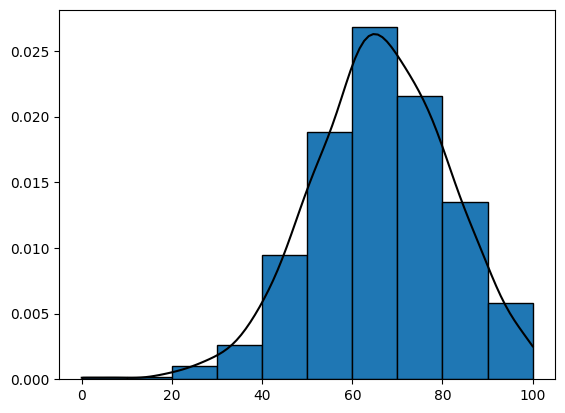

In [51]:
data_1 = ds['math score']
data_2 = ds['math score'][50:100]
plt.hist(data_1, edgecolor='black', density=True)
plt.plot(np.linspace(data_1.min(), data_1.max(), 100), stats.gaussian_kde(data_1)(np.linspace(data_1.min(), data_1.max(), 100)), color='black')

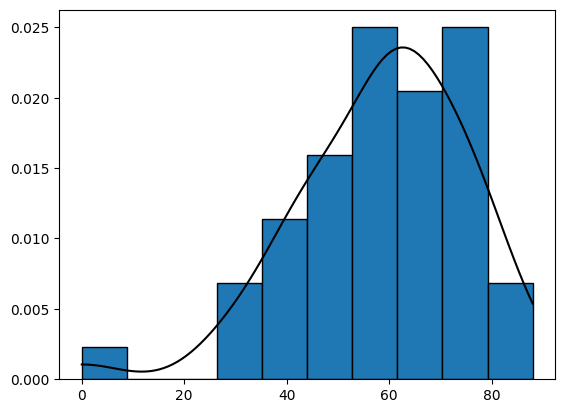

In [52]:
plt.hist(data_2, edgecolor='black', density=True)
plt.plot(np.linspace(data_2.min(), data_2.max(), 100), stats.gaussian_kde(data_2)(np.linspace(data_2.min(), data_2.max(), 100)), color='black')

### 7.1 Квантили

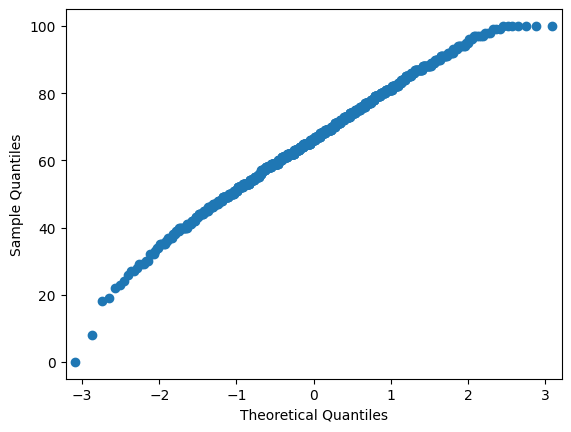

In [53]:
sm.qqplot(data_1)
plt.show()

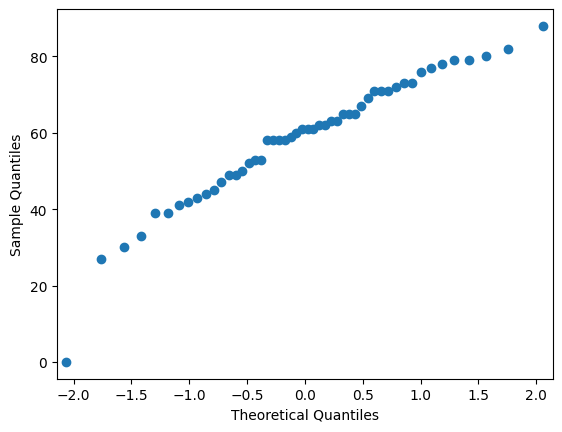

In [54]:
sm.qqplot(data_2)
plt.show()

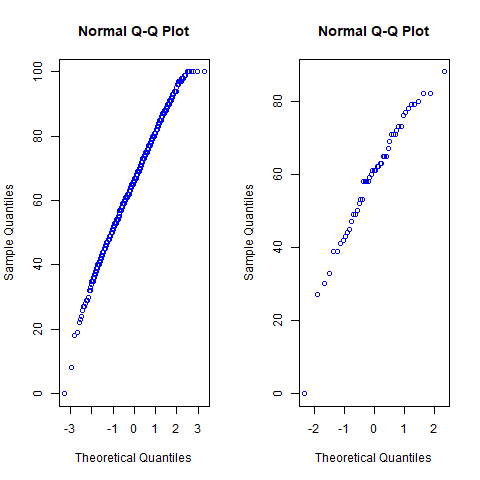

In [55]:
%%R

par(mfrow = c(1, 2))
qqnorm(data_1, col='blue')
qqnorm(data_2, col='blue')

### 7.2 Гипотезы о нормальности

In [56]:
datas = [data_1, data_2]
for i in range(2):
    print("data_" + str(i + 1))
    print(kstest(datas[i], 'norm'))
    print(stats.shapiro(datas[i]))
    print(stats.anderson(datas[i]))
    print(stats.cramervonmises(datas[i], 'norm'))
    print(lilliefors(datas[i], 'norm'))
    print('----------------------------------------------')

data_1
KstestResult(statistic=np.float64(0.9989999999999993), pvalue=np.float64(0.0), statistic_location=np.int64(8), statistic_sign=np.int8(-1))
ShapiroResult(statistic=np.float64(0.9931513872437832), pvalue=np.float64(0.00014545719606603633))
AndersonResult(statistic=np.float64(0.6572122017591937), critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(66.089), scale=np.float64(15.16308009600945))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
CramerVonMisesResult(statistic=332.58383333333336, pvalue=9.931269251417518e-08)
(np.float64(0.030855239411150315), np.float64(0.03566754909869354))
----------------------------------------------
data_2
KstestResult(statistic=np.float64(0.98), pvalue=np.float64(2.251799813685348e-85), statistic_location=np.int64(27), statistic_sign=np.int8(-1))
ShapiroResult(statistic=np.float64(0.9514173259004696),

In [57]:
%%R

print(ks.test(data_1, 'pnorm'))
print(shapiro.test(data_1))
print(ad.test(data_1))
print(cvm.test(data_1))
print(lillie.test(data_1))


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  data_1
D = 0.999, p-value < 2.2e-16
alternative hypothesis: two-sided


	Shapiro-Wilk normality test

data:  data_1
W = 0.99315, p-value = 0.0001455


	Anderson-Darling normality test

data:  data_1
A = 0.65721, p-value = 0.08603


	Cramer-von Mises normality test

data:  data_1
W = 0.09237, p-value = 0.1431


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  data_1
D = 0.030855, p-value = 0.02561



R callback write-console: <class 'UnicodeDecodeError'> 'utf-8' codec can't decode byte 0xe2 in position 1: invalid continuation byte <traceback object at 0x000002127C9ABF40>


In addition: Warning message:
In ks.test.default(data_1, "pnorm") :
 

In [58]:
%%R

print(ks.test(data_2, 'pnorm'))
print(shapiro.test(data_2))
print(ad.test(data_2))
print(cvm.test(data_2))
print(lillie.test(data_2))


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  data_2
D = 0.98039, p-value < 2.2e-16
alternative hypothesis: two-sided


	Shapiro-Wilk normality test

data:  data_2
W = 0.9516, p-value = 0.03678


	Anderson-Darling normality test

data:  data_2
A = 0.47696, p-value = 0.2279


	Cramer-von Mises normality test

data:  data_2
W = 0.071591, p-value = 0.2611


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  data_2
D = 0.12611, p-value = 0.04159



R callback write-console: <class 'UnicodeDecodeError'> 'utf-8' codec can't decode byte 0xe2 in position 1: invalid continuation byte <traceback object at 0x000002127C9BB240>


In addition: Warning message:
In ks.test.default(data_2, "pnorm") :
 